#### Importing important libraries

In [1]:
pip install skops

  Obtaining dependency information for skops from https://files.pythonhosted.org/packages/fd/fd/8ee9d18fa13118f4230766cc31fe66846928eca1713b1907ffd61fa86ed3/skops-0.9.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/120.7 kB ? eta -:--:--
   --- ------------------------------------ 10.2/120.7 kB ? eta -:--:--
   ------------- ------------------------- 41.0/120.7 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 120.7/120.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import skops.io as sio
%matplotlib inline

#### Importing the dataset

In [2]:
df_valid_train = pd.read_csv('cv-valid-train.csv')
df_valid_test = pd.read_csv('cv-valid-test.csv')
df_valid_dev = pd.read_csv('cv-valid-dev.csv')

df_other_train = pd.read_csv('cv-valid-train.csv')
df_other_test = pd.read_csv('cv-valid-test.csv')
df_other_dev = pd.read_csv('cv-valid-dev.csv')

df_invalid = pd.read_csv('cv-invalid.csv')

In [3]:
### Concatenating the dataframes
df = pd.concat([df_valid_train,df_valid_test,df_valid_dev,df_other_train,df_other_test,df_other_dev,df_invalid])

<AxesSubplot:>

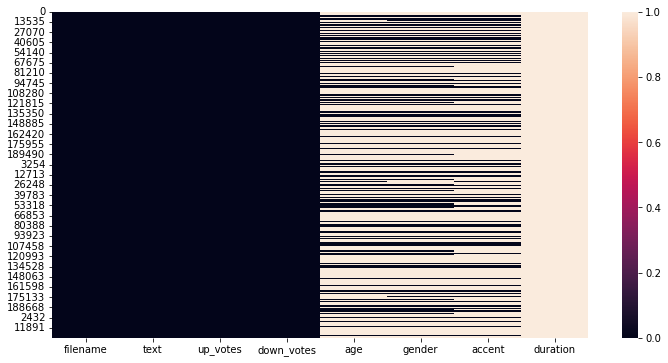

In [4]:
### Checking for the missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull())

In [5]:
### dropping the column because of the missing values
df = df.drop('duration',axis=1)

In [6]:
print(df.shape)
df = df.dropna()
print(df.shape)

(433097, 7)
(136525, 7)


In [7]:
df.head()

filename  \
5   cv-valid-train/sample-000005.mp3   
8   cv-valid-train/sample-000008.mp3   
13  cv-valid-train/sample-000013.mp3   
14  cv-valid-train/sample-000014.mp3   
19  cv-valid-train/sample-000019.mp3   

                                                 text  up_votes  down_votes  \
5   a shepherd may like to travel but he should ne...         1           0   
8                       put jackie right on the staff         3           0   
13  but he had found a guide and didn't want to mi...         1           0   
14  as they began to decorate the hallway a silhou...         1           0   
19   then they got ahold of some dough and went goofy         1           0   

          age  gender     accent  
5    twenties  female         us  
8   seventies    male         us  
13   thirties  female         us  
14    sixties    male    england  
19    fifties    male  australia

In [8]:
### dropping the columns
df = df.drop(['text','up_votes','down_votes'],axis=1)

In [9]:
df.head()

filename        age  gender     accent
5   cv-valid-train/sample-000005.mp3   twenties  female         us
8   cv-valid-train/sample-000008.mp3  seventies    male         us
13  cv-valid-train/sample-000013.mp3   thirties  female         us
14  cv-valid-train/sample-000014.mp3    sixties    male    england
19  cv-valid-train/sample-000019.mp3    fifties    male  australia

In [10]:
df['gender'].value_counts()

male      99194
female    35746
other      1585
Name: gender, dtype: int64

In [13]:
### Removing the observations with other gender due to the underbalance 
index = list(df[df['gender']=='other'].index)

df = df.drop(index)
### resetting the index
df = df.reset_index()
df = df.drop('index', axis = 1)

In [19]:
### Function to change the filename according to the path
def func(fileName):
    
    fileName = fileName.replace('/','\\')
    fileName = 'C:\\Users\\Dell\\Desktop\\Audio Recognition Project\\' + fileName
    return fileName

In [20]:
df['filename'] = df['filename'].apply(lambda x:func(x))

In [21]:
df = df.drop_duplicates(subset=['filename'])

In [22]:
### moving all the files relevant to us to the same folder
def moving(fileName):
    
    source = fileName
    index_m = source.index('m')
    index_v = source.index('v')
    fileName = fileName[index_v-1:index_m-3] + '_' + fileName[index_m-2:]
    destination = 'C:\\Users\\Dell\\Desktop\\Audio Recognition Project\\Final Destination\\' + fileName
    os.rename(source,destination)

In [27]:
for i in range(len(df_invalid)):
    moving(df['filename'][i])

In [60]:
### Saving the dataset
df.to_csv('metadata.csv')

In [2]:
df = pd.read_csv('metadata.csv')

##### converting the audio files to array's

In [28]:
df.head()

filename        age  gender  \
0  C:\Users\Dell\Desktop\Audio Recognition Projec...   twenties  female   
1  C:\Users\Dell\Desktop\Audio Recognition Projec...  seventies    male   
2  C:\Users\Dell\Desktop\Audio Recognition Projec...   thirties  female   
3  C:\Users\Dell\Desktop\Audio Recognition Projec...    sixties    male   
4  C:\Users\Dell\Desktop\Audio Recognition Projec...    fifties    male   

      accent  
0         us  
1         us  
2         us  
3    england  
4  australia

In [29]:
### Changing the filenames to filepaths with all the files in the same folder
def filename_change(fileName):
    
    index = fileName.index('v')
    name = fileName[index-1:].replace('\\','_')[:-3] + 'wav'
    filename = 'C:\\Users\\Dell\\Desktop\\Audio Recognition Project\\Common Voice WAV\\' + name
    return filename

In [30]:
df['filename'] = df['filename'].apply(lambda x:filename_change(x))

In [35]:
df = df.reset_index()
df = df.drop('index',axis=1)

In [36]:
df.to_csv('metadata_final.csv',index=False)

#### Feature Extraction

In [4]:
df = pd.read_csv('metadata_final.csv')

In [18]:
### extract the features from the audio files using mfcc
def feature_extracter(fileName):
    audio,sample_rate = librosa.load(fileName,res_type='kaiser_fast')
    mfcc_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=30)
    mfccs_scaled_features = np.mean(mfcc_features.T, axis=0)
    
    return list(mfccs_scaled_features)

In [19]:
len(feature_extracter('C:\\Users\\Dell\\Desktop\\Audio Recognition Project\\Common Voice WAV\\cv-valid-train_sample-000005.wav'))

128

In [7]:
feature_extraction_dataset = []

In [ ]:
for i in range(len(df)):
    data = feature_extracter(df['filename'][i])
    data.append(df['age'][i])
    data.append(df['gender'][i])
    data.append(df['accent'][i])
    feature_extraction_dataset.append(data)
    #print("{} files completed".format(i))

In [9]:
### converting the list to dataframe
feature_extraction_dataset = pd.DataFrame(feature_extraction_dataset)

In [11]:
feature_extraction_dataset

0           1          2          3          4          5    \
0      -583.109741  100.370453   0.943254  48.706886 -10.540771   0.412921   
1      -394.043793   99.290733 -38.356846  36.202087  13.018510  -0.332277   
2      -329.927063   89.804878 -93.255318  53.524906 -14.073633 -17.782843   
3      -544.498352   80.187973  11.456089  26.149498   8.867408   4.068777   
4      -265.772156  105.103935   9.275388  27.494017   1.308293  28.853981   
...            ...         ...        ...        ...        ...        ...   
69900  -376.485321  119.770882  -0.661368  10.842854  11.884736   4.807947   
69901 -1131.370972    0.000000   0.000000   0.000000   0.000000   0.000000   
69902  -265.763916  114.194046 -22.393890  23.325445  -6.324882  14.880446   
69903  -494.448547   56.549568 -10.677488   6.895159  -0.068489   2.941504   
69904  -461.474670   45.163513 -45.250561  37.988201  -2.061493 -11.344541   

             6          7          8          9    ...       121       122  \
0     -18.057110  -8.326262  -1.521947 -12.522870  ... -0.192631 -0.315564   
1     -30.521049 -24.611736 -20.024382  -8.018195  ... -0.181873 -0.617222   
2     -30.973644 -11.115297   1.704327 -15.689195  ... -0.064750 -0.154670   
3      -5.959950  -0.991863  -5.118737  -1.111087  ... -0.293615 -0.154340   
4     -11.553514  19.866306  -9.072405  16.467325  ... -0.064412 -0.548103   
...          ...        ...        ...        ...  ...       ...       ...   
69900   0.221877  14.571591  -7.106067   8.881387  ... -0.514412 -0.419168   
69901   0.000000   0.000000   0.000000   0.000000  ...  0.000000  0.000000   
69902  -5.550321   8.608303  -9.489439   4.931038  ... -1.028494 -0.561055   
69903 -14.531470   2.231544  -4.246867  -1.574609  ...  0.236807  0.881689   
69904 -11.862006   2.977398 -10.133149  -1.859840  ...  0.341581  0.253553   

            123       124       125       126       127        128     129  \
0      0.343298 -0.402466  0.258311 -0.296783  0.058532   twenties  female   
1     -0.203300  0.066065  0.179560 -0.035815  0.082535  seventies    male   
2      0.144096  0.340831  0.397898  0.183917 -0.035574   thirties  female   
3     -0.152312 -0.136096 -0.248668 -0.185580 -0.021339    sixties    male   
4     -0.691253 -0.090602 -0.078694 -0.036180 -0.491893    fifties    male   
...         ...       ...       ...       ...       ...        ...     ...   
69900  0.386208  0.013728 -0.990892 -0.474937 -0.042218      teens    male   
69901  0.000000  0.000000  0.000000  0.000000  0.000000    sixties    male   
69902 -0.638143 -0.282054 -0.419412 -0.193380  0.354584   twenties    male   
69903  0.132002 -0.214825  0.143224  0.034405 -0.521862    sixties  female   
69904  0.186000 -0.078874  0.110601  0.018772  0.275380   fourties    male   

             130  
0             us  
1             us  
2             us  
3        england  
4      australia  
...          ...  
69900         us  
69901         us  
69902     indian  
69903         us  
69904  australia  

[69905 rows x 131 columns]

In [ ]:
### naming the features for convenience
col_name = []
for i in range(1,31):
    col_name.append('Feature_'+str(i))
col_name = col_name + ['age','gender','accent']
feature_extraction_dataset.columns = col_name

In [9]:
feature_extraction_dataset.head()

Feature_1   Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0 -583.109741  100.370453   0.943255  48.706882 -10.540771   0.412921   
1 -394.043793   99.290733 -38.356846  36.202087  13.018513  -0.332277   
2 -329.927063   89.804886 -93.255318  53.524906 -14.073632 -17.782843   
3 -544.498291   80.187973  11.456089  26.149498   8.867408   4.068777   
4 -265.772156  105.103935   9.275387  27.494017   1.308293  28.853981   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_24  Feature_25  \
0 -18.057110  -8.326262  -1.521946  -12.522870  ...   -2.081630   -4.345325   
1 -30.521049 -24.611736 -20.024382   -8.018195  ...   -5.490204   -5.979488   
2 -30.973644 -11.115298   1.704327  -15.689195  ...   -2.942057   -3.899509   
3  -5.959950  -0.991863  -5.118737   -1.111087  ...   -3.014753   -1.035969   
4 -11.553512  19.866306  -9.072405   16.467325  ...    1.660018   -2.550889   

   Feature_26  Feature_27  Feature_28  Feature_29  Feature_30        age  \
0   -5.543271    0.867665   -2.325722   -4.993744   -2.170289   twenties   
1   -5.525753   -3.199488  -12.229231    2.510893   -1.527913  seventies   
2    5.903738   -2.495930    4.284184    2.987215   -1.986013   thirties   
3   -4.900939   -1.521831   -3.017688   -1.510514    2.014324    sixties   
4    1.886928   -5.248073    1.555064   -0.886034   -0.406267    fifties   

   gender     accent  
0  female         us  
1    male         us  
2  female         us  
3    male    england  
4    male  australia  

[5 rows x 33 columns]

In [10]:
feature_extraction_dataset.to_csv('features_data.csv',index=False)

#### Exploratory Data Analysis

In [24]:
df_features = pd.read_csv('features_data.csv')

In [25]:
df_features['male'].value_counts()

1    51284
0    18621
Name: male, dtype: int64

In [30]:
df_features.head()

Feature_1   Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0 -583.10974  100.370450   0.943255  48.706882 -10.540771   0.412921   
1 -394.04380   99.290730 -38.356846  36.202087  13.018513  -0.332277   
2 -329.92706   89.804886 -93.255320  53.524906 -14.073632 -17.782843   
3 -544.49830   80.187970  11.456089  26.149498   8.867408   4.068777   
4 -265.77216  105.103935   9.275387  27.494017   1.308293  28.853981   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_30  male  \
0 -18.057110  -8.326262  -1.521946  -12.522870  ...   -2.170289     0   
1 -30.521050 -24.611736 -20.024382   -8.018195  ...   -1.527913     1   
2 -30.973644 -11.115298   1.704327  -15.689195  ...   -1.986013     0   
3  -5.959950  -0.991863  -5.118737   -1.111087  ...    2.014324     1   
4 -11.553512  19.866306  -9.072405   16.467325  ...   -0.406267     1   

   age_label  fifties  fourties  seventies  sixties  teens  thirties  twenties  
0          7        0         0          0        0      0         0         1  
1          3        0         0          1        0      0         0         0  
2          6        0         0          0        0      0         1         0  
3          4        0         0          0        1      0         0         0  
4          1        1         0          0        0      0         0         0  

[5 rows x 39 columns]

<AxesSubplot:xlabel='age_label', ylabel='Count'>

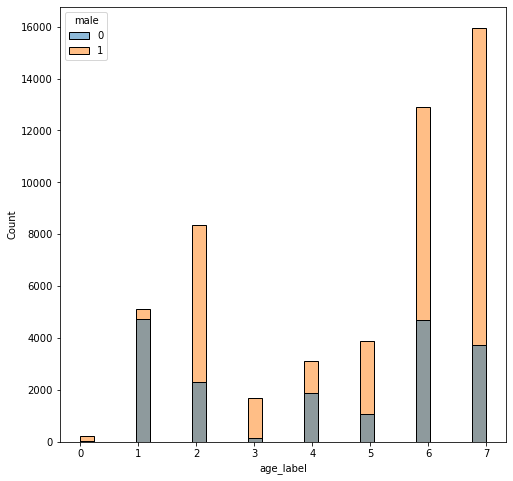

In [29]:
plt.figure(figsize=(8,8))
sns.histplot(x='age_label',data=df_features,hue='male')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

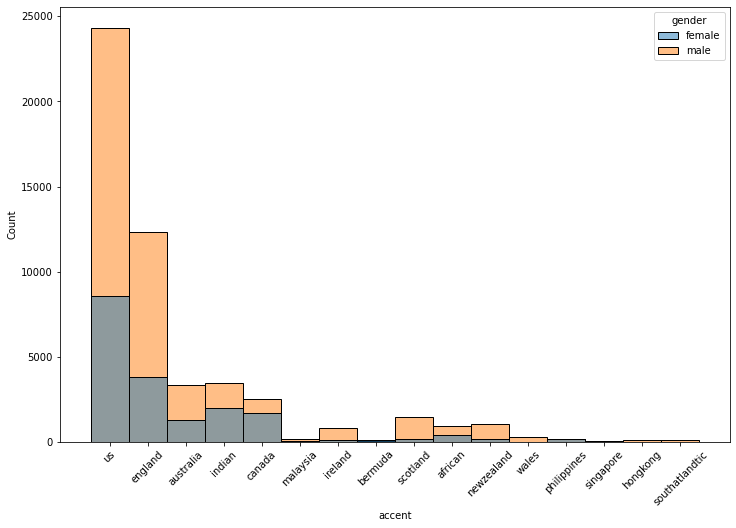

In [14]:
plt.figure(figsize=(12,8))
ax = sns.histplot(x='accent',data=df_features,hue='gender')
plt.xticks(rotation=45)

In [15]:
### dropping the accent column because of the imbalanced dataset
df_features = df_features.drop('accent',axis=1)

Label 0: female || 1: male

In [16]:
### hot encoding the gender attribute
gender = pd.get_dummies(df_features['gender'],drop_first=True)
df_features = df_features.drop('gender',axis=1)
df_features = pd.concat([df_features,gender],axis=1)

Label 7: twenties ||
6: thirties ||
2: fourties ||
1: fifties ||
4: sixties ||
5: teens ||
3: seventies ||
0: eighties 

In [17]:
from sklearn.preprocessing import LabelEncoder

In [22]:
### label encoding the age attribute
encoding = LabelEncoder()
encoding.fit(df_features['age'])
age = encoding.transform(df_features['age'])
age = pd.DataFrame(age,columns=['age_label'])
df_features = pd.concat([df_features,age],axis=1)

In [24]:
### hot encoding the age attribute
age = pd.get_dummies(df_features['age'],drop_first=True)
df_features = df_features.drop('age',axis=1)
df_features = pd.concat([df_features,age],axis=1)

In [25]:
df_features.to_csv('features_data.csv',index=False)

In [3]:
df_features = pd.read_csv('features_data.csv')

In [4]:
df_features.head()

Feature_1   Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0 -583.10974  100.370450   0.943255  48.706882 -10.540771   0.412921   
1 -394.04380   99.290730 -38.356846  36.202087  13.018513  -0.332277   
2 -329.92706   89.804886 -93.255320  53.524906 -14.073632 -17.782843   
3 -544.49830   80.187970  11.456089  26.149498   8.867408   4.068777   
4 -265.77216  105.103935   9.275387  27.494017   1.308293  28.853981   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_30  male  \
0 -18.057110  -8.326262  -1.521946  -12.522870  ...   -2.170289     0   
1 -30.521050 -24.611736 -20.024382   -8.018195  ...   -1.527913     1   
2 -30.973644 -11.115298   1.704327  -15.689195  ...   -1.986013     0   
3  -5.959950  -0.991863  -5.118737   -1.111087  ...    2.014324     1   
4 -11.553512  19.866306  -9.072405   16.467325  ...   -0.406267     1   

   age_label  fifties  fourties  seventies  sixties  teens  thirties  twenties  
0          7        0         0          0        0      0         0         1  
1          3        0         0          1        0      0         0         0  
2          6        0         0          0        0      0         1         0  
3          4        0         0          0        1      0         0         0  
4          1        1         0          0        0      0         0         0  

[5 rows x 39 columns]

#### Train Test Split

In [5]:
df_features = df_features.drop(['fifties','fourties','seventies','sixties','teens','thirties','twenties'], axis = 1)

In [6]:
df_features.head()

Feature_1   Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0 -583.10974  100.370450   0.943255  48.706882 -10.540771   0.412921   
1 -394.04380   99.290730 -38.356846  36.202087  13.018513  -0.332277   
2 -329.92706   89.804886 -93.255320  53.524906 -14.073632 -17.782843   
3 -544.49830   80.187970  11.456089  26.149498   8.867408   4.068777   
4 -265.77216  105.103935   9.275387  27.494017   1.308293  28.853981   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_23  Feature_24  \
0 -18.057110  -8.326262  -1.521946  -12.522870  ...  -10.564928   -2.081630   
1 -30.521050 -24.611736 -20.024382   -8.018195  ...   -1.825251   -5.490204   
2 -30.973644 -11.115298   1.704327  -15.689195  ...   -2.550232   -2.942057   
3  -5.959950  -0.991863  -5.118737   -1.111087  ...   -4.689697   -3.014753   
4 -11.553512  19.866306  -9.072405   16.467325  ...   -0.586617    1.660018   

   Feature_25  Feature_26  Feature_27  Feature_28  Feature_29  Feature_30  \
0   -4.345325   -5.543271    0.867665   -2.325722   -4.993744   -2.170289   
1   -5.979488   -5.525754   -3.199488  -12.229231    2.510893   -1.527913   
2   -3.899509    5.903738   -2.495930    4.284184    2.987215   -1.986013   
3   -1.035969   -4.900939   -1.521831   -3.017688   -1.510514    2.014324   
4   -2.550889    1.886928   -5.248073    1.555064   -0.886034   -0.406267   

   male  age_label  
0     0          7  
1     1          3  
2     0          6  
3     1          4  
4     1          1  

[5 rows x 32 columns]

In [7]:
X = df_features.drop(['male','age_label'],axis=1)
y = df_features[['male','age_label']]

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=101)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(62914, 30)
(6991, 30)
(62914, 2)
(6991, 2)


In [11]:
col_name = list(X_train.columns)

#### Feature Normalization

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
sio.dump(scaler, 'scaler')

In [18]:
X_train = pd.DataFrame(X_train,columns=col_name)
X_test = pd.DataFrame(X_test,columns=col_name)

In [19]:
y_train = y_train.reset_index()
y_train = y_train.drop('index',axis=1)

y_test = y_test.reset_index()
y_test = y_test.drop('index',axis=1)

In [41]:
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
y_test.to_csv('y_test.csv',index=False)

### Gender Classification

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [20]:
X_train.head()

Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.564395   0.353829  -0.278928   0.244259  -0.181786  -0.359068   
1  -1.267875  -2.791355  -0.087076   1.215719  -0.609884  -0.713474   
2   1.255162  -0.192609   0.540949  -1.715435   0.274440   2.556369   
3  -1.142260  -0.058441   0.073180   0.767581  -0.707162   0.221958   
4  -0.242462  -0.681530  -0.062332  -0.463858  -1.458397   0.806520   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_21  Feature_22  \
0  -0.434922   0.421213  -2.619306   -0.233284  ...   -0.752095   -0.047534   
1  -0.228118  -1.044130   0.946386   -0.418563  ...    1.012054    1.152340   
2  -1.519288   0.040003  -0.116192    0.200872  ...    0.452080   -0.511977   
3  -0.094128   0.026847  -0.713516    0.806025  ...   -1.707473    0.421067   
4  -0.685224   0.200540  -0.058170    0.478191  ...    0.820614    0.000589   

   Feature_23  Feature_24  Feature_25  Feature_26  Feature_27  Feature_28  \
0   -1.596541   -2.185107   -0.475254   -2.322643   -0.664499   -1.974565   
1    0.962649    1.060207    1.568758    1.971719    1.215556    2.248357   
2    0.175765   -0.709609   -1.761413   -0.222903   -0.364405   -1.224240   
3    0.210689    0.256840   -0.117659   -0.285450   -1.195636   -0.097772   
4   -0.148946    0.207631    0.275857   -0.189223   -0.384763   -0.225240   

   Feature_29  Feature_30  
0   -0.852845    0.497673  
1    0.764481    0.759086  
2    0.260271   -0.052288  
3   -0.528391   -0.231970  
4    0.261362   -0.031957  

[5 rows x 30 columns]

In [21]:
y_gender_train = y_train['male']
y_gender_test = y_test['male']

##### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
model = LogisticRegression()
model.fit(X_train,y_gender_train)
pred = model.predict(X_test)

In [47]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

In [48]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.8915752278222058

0.8332141324560148

[[1031  317]
 [ 849 4794]]

              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1348
           1       0.94      0.85      0.89      5643

    accuracy                           0.83      6991
   macro avg       0.74      0.81      0.77      6991
weighted avg       0.86      0.83      0.84      6991



##### KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
model = KNeighborsClassifier()
model.fit(X_train,y_gender_train)
pred = model.predict(X_test.values)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [25]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [26]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.9548720896809427

0.9326276641396081

[[1537  128]
 [ 343 4983]]

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1665
           1       0.97      0.94      0.95      5326

    accuracy                           0.93      6991
   macro avg       0.90      0.93      0.91      6991
weighted avg       0.94      0.93      0.93      6991



In [27]:
sio.dump(model,'KNN_gender_detection')

##### SVM

In [52]:
from sklearn.svm import SVC

In [ ]:
model = SVC(C=100)
model.fit(X_train,y_gender_train)
pred = model.predict(X_test)

In [8]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.9528063701689649

0.9304820483478758

[[1599  205]
 [ 281 4906]]

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1804
           1       0.96      0.95      0.95      5187

    accuracy                           0.93      6991
   macro avg       0.91      0.92      0.91      6991
weighted avg       0.93      0.93      0.93      6991



##### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
model = DecisionTreeClassifier()
model.fit(X_train,y_gender_train)
pred = model.predict(X_test)

In [11]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.8603625673689368

0.7961664997854384

[[1176  721]
 [ 704 4390]]

              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1897
           1       0.86      0.86      0.86      5094

    accuracy                           0.80      6991
   macro avg       0.74      0.74      0.74      6991
weighted avg       0.80      0.80      0.80      6991



##### Bagging Decision Tree

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [13]:
model = BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
model.fit(X_train, y_gender_train)
pred = model.predict(X_test)

In [197]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.9014679075122326

0.8530968387927336

[[1266  413]
 [ 614 4698]]

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1679
           1       0.92      0.88      0.90      5312

    accuracy                           0.85      6991
   macro avg       0.80      0.82      0.81      6991
weighted avg       0.86      0.85      0.86      6991



##### Boosting Decision Tree

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
model = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
model.fit(X_train, y_gender_train)
pred = model.predict(X_test)

In [17]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.89351376574895

0.8367901587755686

[[1063  324]
 [ 817 4787]]

              precision    recall  f1-score   support

           0       0.57      0.77      0.65      1387
           1       0.94      0.85      0.89      5604

    accuracy                           0.84      6991
   macro avg       0.75      0.81      0.77      6991
weighted avg       0.86      0.84      0.85      6991



##### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model = RandomForestClassifier()
model.fit(X_train,y_gender_train)
pred = model.predict(X_test)

In [203]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.9218778994247543

0.8795594335574309

[[1181  143]
 [ 699 4968]]

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      1324
           1       0.97      0.88      0.92      5667

    accuracy                           0.88      6991
   macro avg       0.80      0.88      0.83      6991
weighted avg       0.91      0.88      0.89      6991



##### Neural Network 

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [118]:
# CODE HERE
model = Sequential()

model.add(Dense(30,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16,activation='relu',kernel_regularizer = regularizers.l2(0.01)))
#model.add(Dropout(0.2))
#model.add(Dense(7,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(18,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(9,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(4,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(2,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

In [119]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [120]:
model.fit(X_train,y_gender_train,epochs=90,batch_size=256,validation_data=(X_test,y_gender_test))

Epoch 1/90
246/246 [==============================] - 3s 6ms/step - loss: 0.4370 - accuracy: 0.8056 - val_loss: 0.3802 - val_accuracy: 0.8431
Epoch 2/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3585 - accuracy: 0.8514 - val_loss: 0.3550 - val_accuracy: 0.8517
Epoch 3/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3408 - accuracy: 0.8582 - val_loss: 0.3432 - val_accuracy: 0.8582
Epoch 4/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3298 - accuracy: 0.8633 - val_loss: 0.3345 - val_accuracy: 0.8600
Epoch 5/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3218 - accuracy: 0.8672 - val_loss: 0.3273 - val_accuracy: 0.8640
Epoch 6/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3159 - accuracy: 0.8699 - val_loss: 0.3221 - val_accuracy: 0.8667
Epoch 7/90
246/246 [==============================] - 1s 5ms/step - loss: 0.3111 - accuracy: 0.8722 - val_loss: 0.3189 - val_accuracy: 0.8654
Epoch 

In [121]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 30)                930       
                                                                 
 dense_36 (Dense)            (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
None


<AxesSubplot:>

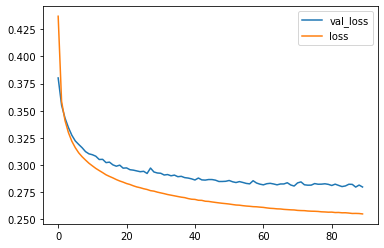

In [122]:
# CODE HERE
losses = pd.DataFrame(model.history.history)
losses[['val_loss','loss']].plot()

In [123]:
pred = (model.predict(X_test) > 0.5).astype("int32")

219/219 [==============================] - 1s 3ms/step


In [124]:
print(f1_score(pred,y_gender_test))
print()
print(accuracy_score(pred,y_gender_test))
print()
print(confusion_matrix(pred,y_gender_test))
print()
print(classification_report(pred,y_gender_test))

0.9228705566733736

0.8848519525103705

[[1370  295]
 [ 510 4816]]

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1665
           1       0.94      0.90      0.92      5326

    accuracy                           0.88      6991
   macro avg       0.84      0.86      0.85      6991
weighted avg       0.89      0.88      0.89      6991



### Age Category Classification

In [28]:
y_age_train = y_train['age_label']
y_age_test = y_test['age_label']

##### Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
model = LogisticRegression(max_iter=10000000000000)
model.fit(X_train,y_age_train)
pred = model.predict(X_test)

In [105]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.37658227933088945

0.32770705192390215

[[   0    1    1    0    0    0    0    1]
 [   1   87   60    5   48   21   43   70]
 [   1   73  134   14   22   24  134   96]
 [   0    1    0    3    0    2    0    2]
 [   0   14   15    2   25    4   12   12]
 [   0    5    7    0    0   28    9    4]
 [   8  386  319   76  194  121  805  566]
 [  17  429  517   83  198  295  787 1209]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.09      0.26      0.13       335
           2       0.13      0.27      0.17       498
           3       0.02      0.38      0.03         8
           4       0.05      0.30      0.09        84
           5       0.06      0.53      0.10        53
           6       0.45      0.33      0.38      2475
           7       0.62      0.34      0.44      3535

    accuracy                           0.33      6991
   macro avg       0.18      0.30      0.17      6991
weighted avg    

##### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
model = KNeighborsClassifier()
model.fit(X_train,y_age_train)
pred = model.predict(X_test.values)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [32]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.7962944851183236

0.795737376627092

[[  18    2    0    0    2    1    3    5]
 [   0  852   41    7   18   33   79   94]
 [   2   19  861    3   10   24   77   96]
 [   0    1    3  154    4    4   14   10]
 [   0   15   21    2  413   12   29   43]
 [   0    5    2    1    2  325   21   21]
 [   6   60   64    8   28   48 1478  229]
 [   1   42   61    8   10   48   89 1462]]

              precision    recall  f1-score   support

           0       0.67      0.58      0.62        31
           1       0.86      0.76      0.80      1124
           2       0.82      0.79      0.80      1092
           3       0.84      0.81      0.83       190
           4       0.85      0.77      0.81       535
           5       0.66      0.86      0.75       377
           6       0.83      0.77      0.80      1921
           7       0.75      0.85      0.79      1721

    accuracy                           0.80      6991
   macro avg       0.78      0.77      0.77      6991
weighted avg       

In [110]:
joblib.dump(model, 'KNN_age_model')

['KNN_age_model.pkl']

##### SVM

In [111]:
from sklearn.svm import SVC

In [ ]:
model = SVC(C=1)
model.fit(X_train,y_age_train)
pred = model.predict(X_test)

In [152]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.7614100194796487

0.7608353597482478

[[  20    0    1    0    1    0    1    2]
 [   1  798   25    6   16   18   68   92]
 [   1   22  790    5   12   32   55   95]
 [   0    1    2  135    1    1    6    9]
 [   0    3   11    1  373    5   20   26]
 [   0    8   10    1    8  289   22   32]
 [   4   79   98   11   37   62 1413  203]
 [   1   85  116   24   39   88  205 1501]]

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        25
           1       0.80      0.78      0.79      1024
           2       0.75      0.78      0.77      1012
           3       0.74      0.87      0.80       155
           4       0.77      0.85      0.81       439
           5       0.58      0.78      0.67       370
           6       0.79      0.74      0.76      1907
           7       0.77      0.73      0.75      2059

    accuracy                           0.76      6991
   macro avg       0.74      0.79      0.76      6991
weighted avg      

##### Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
model = DecisionTreeClassifier()
model.fit(X_train,y_age_train)
pred = model.predict(X_test)

In [8]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.40225615103109547

0.40208839937061935

[[  6   0   1   1   0   1   4   7]
 [  3 409  95  28  48  40 204 195]
 [  4 107 399  23  52  61 175 216]
 [  0  20  15  37   4   6  50  42]
 [  2  46  59  11 201  19  85 104]
 [  4  50  49  11  22 126 106 126]
 [  4 175 204  37  83  96 758 395]
 [  4 189 231  35  77 146 408 875]]

              precision    recall  f1-score   support

           0       0.22      0.30      0.26        20
           1       0.41      0.40      0.41      1022
           2       0.38      0.38      0.38      1037
           3       0.20      0.21      0.21       174
           4       0.41      0.38      0.40       527
           5       0.25      0.26      0.25       494
           6       0.42      0.43      0.43      1752
           7       0.45      0.45      0.45      1965

    accuracy                           0.40      6991
   macro avg       0.34      0.35      0.35      6991
weighted avg       0.40      0.40      0.40      6991



##### Bagging Decision Tree

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
model = BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
model.fit(X_train, y_age_train)
pred = model.predict(X_test)

In [11]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.5177393450250413

0.512516092118438

[[   3    0    0    0    0    0    0    0]
 [   0  553   77   19   48   52  157  169]
 [   6   87  525   23   43   54  180  179]
 [   0    0    6   57    1    1    4    3]
 [   1   15   16    3  197    9   22   30]
 [   2   13   12    2    6  122   29   39]
 [   7  164  196   41   97  114 1023  437]
 [   8  164  221   38   95  143  375 1103]]

              precision    recall  f1-score   support

           0       0.11      1.00      0.20         3
           1       0.56      0.51      0.53      1075
           2       0.50      0.48      0.49      1097
           3       0.31      0.79      0.45        72
           4       0.40      0.67      0.51       293
           5       0.25      0.54      0.34       225
           6       0.57      0.49      0.53      2079
           7       0.56      0.51      0.54      2147

    accuracy                           0.51      6991
   macro avg       0.41      0.63      0.45      6991
weighted avg       

##### Boosting Decision Tree

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [13]:
model = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
model.fit(X_train, y_age_train)
pred = model.predict(X_test)

In [14]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.395014876392853

0.3428694035188099

[[   2    0    0    0    0    0    0    0]
 [   1  131   41    2   26    8   43   43]
 [   1   40  125    7   13   20   70   69]
 [   0    0    2    2    0    1    0    1]
 [   0    5    2    3   28    1    5    8]
 [   0    6    7    0    1   19    6    9]
 [   8  324  310   94  161  130  763  503]
 [  15  490  566   75  258  316  903 1327]]

              precision    recall  f1-score   support

           0       0.07      1.00      0.14         2
           1       0.13      0.44      0.20       295
           2       0.12      0.36      0.18       345
           3       0.01      0.33      0.02         6
           4       0.06      0.54      0.10        52
           5       0.04      0.40      0.07        48
           6       0.43      0.33      0.37      2293
           7       0.68      0.34      0.45      3950

    accuracy                           0.34      6991
   macro avg       0.19      0.47      0.19      6991
weighted avg       

##### Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
model = RandomForestClassifier()
model.fit(X_train,y_age_train)
pred = model.predict(X_test)

In [17]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.6567027435146164

0.6501215848948648

[[   6    0    0    0    0    0    0    1]
 [   0  602   16    2   15   16   22   30]
 [   1   20  587    8   10   11   39   50]
 [   0    0    0   71    0    0    0    0]
 [   0    1    4    1  251    0    0    3]
 [   0    1    1    0    0  123    0    2]
 [  12  155  181   48  106  110 1343  312]
 [   8  217  264   53  105  235  386 1562]]

              precision    recall  f1-score   support

           0       0.22      0.86      0.35         7
           1       0.60      0.86      0.71       703
           2       0.56      0.81      0.66       726
           3       0.39      1.00      0.56        71
           4       0.52      0.97      0.67       260
           5       0.25      0.97      0.40       127
           6       0.75      0.59      0.66      2267
           7       0.80      0.55      0.65      2830

    accuracy                           0.65      6991
   macro avg       0.51      0.83      0.58      6991
weighted avg      

##### XG Boost

In [4]:
import xgboost as xgb

In [5]:
model = xgb.XGBClassifier()
model.fit(X_train, y_age_train)
pred = model.predict(X_test)

In [7]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.5942879832278003

0.5903304248319268

[[  10    0    0    0    0    0    0    1]
 [   1  590   46   10   23   15   69   75]
 [   4   44  511    6   21   24   88  109]
 [   0    1    3   89    2    0    4    7]
 [   0   12   17    2  242    4   15   14]
 [   0    7   12    1    2  148   16   25]
 [   5  149  198   44  115  107 1149  341]
 [   7  193  266   31   82  197  449 1388]]

              precision    recall  f1-score   support

           0       0.37      0.91      0.53        11
           1       0.59      0.71      0.65       829
           2       0.49      0.63      0.55       807
           3       0.49      0.84      0.62       106
           4       0.50      0.79      0.61       306
           5       0.30      0.70      0.42       211
           6       0.64      0.55      0.59      2108
           7       0.71      0.53      0.61      2613

    accuracy                           0.59      6991
   macro avg       0.51      0.71      0.57      6991
weighted avg      

#### Neural Network

##### Deep Learning

In [5]:
y_age_train = y_train.drop(['male','age_label'],axis=1)
y_age_test = y_test.drop(['male','age_label'],axis=1)

In [4]:
from keras import layers, models, optimizers, losses, metrics
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [138]:
# CODE HERE
model = Sequential()

model.add(InputLayer(input_shape=30))
model.add(Dense(200,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(150,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(112,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(84,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(63,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(48,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(36,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(27,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(21,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(15,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(2,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(7,activation='softmax'))

In [139]:
earlystop = EarlyStopping(monitor='val_loss',patience=3)

In [140]:
losses = {'output_1':'binary_crossentropy'}

In [141]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
model.fit(X_train,y_age_train,epochs=190,batch_size=256,validation_data=(X_test,y_age_test),callbacks=earlystop)

Epoch 1/190
246/246 [==============================] - 2s 5ms/step - loss: 0.4140 - accuracy: 0.2937 - val_loss: 0.3690 - val_accuracy: 0.3084
Epoch 2/190
246/246 [==============================] - 1s 6ms/step - loss: 0.3592 - accuracy: 0.3581 - val_loss: 0.3444 - val_accuracy: 0.4048
Epoch 3/190
246/246 [==============================] - 1s 4ms/step - loss: 0.3289 - accuracy: 0.4509 - val_loss: 0.3136 - val_accuracy: 0.4765
Epoch 4/190
246/246 [==============================] - 1s 5ms/step - loss: 0.2974 - accuracy: 0.5149 - val_loss: 0.2925 - val_accuracy: 0.5207
Epoch 5/190
246/246 [==============================] - 1s 5ms/step - loss: 0.2715 - accuracy: 0.5697 - val_loss: 0.2727 - val_accuracy: 0.5726
Epoch 6/190
246/246 [==============================] - 1s 5ms/step - loss: 0.2508 - accuracy: 0.6116 - val_loss: 0.2630 - val_accuracy: 0.5870
Epoch 7/190
246/246 [==============================] - 1s 4ms/step - loss: 0.2356 - accuracy: 0.6410 - val_loss: 0.2547 - val_accuracy: 0.6068

In [143]:
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 200)               6200      
                                                                 
 dense_252 (Dense)           (None, 150)               30150     
                                                                 
 dense_253 (Dense)           (None, 112)               16912     
                                                                 
 dense_254 (Dense)           (None, 84)                9492      
                                                                 
 dense_255 (Dense)           (None, 63)                5355      
                                                                 
 dense_256 (Dense)           (None, 48)                3072      
                                                                 
 dense_257 (Dense)           (None, 36)              

<AxesSubplot:>

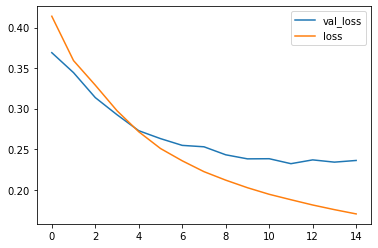

In [144]:
# CODE HERE
losses = pd.DataFrame(model.history.history)
losses[['val_loss','loss']].plot()

In [145]:
pred = (model.predict(X_test) > 0.5).astype("int32")

219/219 [==============================] - 1s 3ms/step


In [146]:
print(f1_score(pred,y_age_test,average='weighted'))
print()
print(accuracy_score(pred,y_age_test))
print()
#print(confusion_matrix(pred,y_age_test))
print()
print(classification_report(pred,y_age_test))

0.6595140112999031

0.6076383922185667


              precision    recall  f1-score   support

           0       0.65      0.79      0.71       821
           1       0.58      0.75      0.66       810
           2       0.47      0.80      0.59       107
           3       0.62      0.75      0.68       403
           4       0.35      0.73      0.48       237
           5       0.60      0.71      0.65      1514
           6       0.69      0.65      0.67      2075

   micro avg       0.61      0.71      0.66      5967
   macro avg       0.57      0.74      0.63      5967
weighted avg       0.62      0.71      0.66      5967
 samples avg       0.61      0.61      0.61      5967



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Real Time Model Testing

In [11]:
import joblib

In [12]:
## Voice Data Feature Extraction

### extract the features from the audio files using mfcc
def feature_extracter(fileName):
    audio,sample_rate = librosa.load(fileName,res_type='kaiser_fast')
    mfcc_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=30)
    mfccs_scaled_features = np.mean(mfcc_features.T, axis=0)
    
    return list(mfccs_scaled_features)

In [37]:
fileName = 'C:\\Users\\Dell\\Downloads\\narendra-modi-walking-out-of-karan-thapar-interview-tuberippercom_R89R3fPq.wav'
col_name = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5','Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10','Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15','Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20','Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25','Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30']

In [38]:
observation = [feature_extracter(fileName)]
observation = pd.DataFrame(observation, columns = col_name)

In [39]:
## scaling the observation
scaler = joblib.load('scaler.pkl')
scaled_observation = scaler.transform(observation)
scaled_observation = pd.DataFrame(scaled_observation, columns = col_name)

In [40]:
### Gender classification model
gender_model = joblib.load('KNN_gender_detection.pkl')
gender_predict = gender_model.predict(scaled_observation)
## considering the labels 1 = male 0 = female
if gender_predict[0] == 1:
    print('Male')
else:
    print('Female')

Male


In [41]:
def age_reverse_labelling(label):
    if label == 0:
        return 'Eighties'
    if label == 1:
        return 'Fifties'
    if label == 2:
        return 'Fourties'
    if label == 3:
        return 'Seventies'
    if label == 4:
        return 'Sixties'
    if label == 5:
        return 'Teens'
    if label == 6:
        return 'Thirties'
    if label == 7:
        return 'Twenties'
    else:
        return 'Cannot be predicted'

In [42]:
### Age classification model
age_model = joblib.load('KNN_age_model.pkl')
age_predict = age_model.predict(scaled_observation)
## considering the labels 1 = male 0 = female
print(age_reverse_labelling(age_predict[0]))

Twenties
